In [98]:
# IMPORTS
# A TOF coords adaptation of the listmode PET scan reconstruction from: https://pytomography.readthedocs.io/en/latest/notebooks/t_PETGATE_scat_lm.html

from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, MLEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.utils import sss

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# torch.cuda.is_available = lambda: False
print(f"CUDA available: {torch.cuda.is_available()}")
# pytomography.device = 'cpu'
print(f"Current device: {pytomography.device}")
torch.cuda.empty_cache()

CUDA available: False
Current device: cpu


In [99]:
# # Visualisation Functions
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider


def visualize_voxel_tensor_3d(voxel_tensor, initial_min_threshold=None, initial_max_threshold=None, 
                               voxel_size_mm=1.0, world_origin=None, min_threshold=None, max_threshold=None):
    """
    Interactive 3D visualization of voxel tensor with dual threshold sliders.

    Args:
        voxel_tensor: (nx, ny, nz) numpy array with voxel counts
        initial_min_threshold: Initial minimum threshold value for the slider (default: min_val)
        initial_max_threshold: Initial maximum threshold value for the slider (default: max_val)
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
        world_origin: (x_min, y_min, z_min) world coordinates of voxel (0,0,0) (optional)
        min_threshold: Minimum threshold value for slider range (optional)
        max_threshold: Maximum threshold value for slider range (optional)
    """
    # Extract non-zero voxel coordinates and values
    coords = np.where(voxel_tensor > 0)
    x_coords, y_coords, z_coords = coords
    values = voxel_tensor[coords]

    # Convert voxel indices to world coordinates if world_origin provided
    if world_origin is not None:
        x_min, y_min, z_min = world_origin
        x_coords_world = x_coords * voxel_size_mm + x_min
        y_coords_world = y_coords * voxel_size_mm + y_min
        z_coords_world = z_coords * voxel_size_mm + z_min
        coord_suffix = " (mm)"
    else:
        x_coords_world = x_coords * voxel_size_mm
        y_coords_world = y_coords * voxel_size_mm
        z_coords_world = z_coords * voxel_size_mm
        coord_suffix = f" (×{voxel_size_mm}mm)"

    # Get value range for sliders
    min_val = float(np.min(values))
    max_val = float(np.max(values))

    # Use user-specified min/max threshold range if provided
    slider_min = min_threshold if min_threshold is not None else min_val
    slider_max = max_threshold if max_threshold is not None else max_val

    # Set initial thresholds with defaults
    if initial_min_threshold is None:
        initial_min_threshold = slider_min
    else:
        initial_min_threshold = max(slider_min, min(slider_max, float(initial_min_threshold)))
    
    if initial_max_threshold is None:
        initial_max_threshold = slider_max
    else:
        initial_max_threshold = max(slider_min, min(slider_max, float(initial_max_threshold)))

    # Ensure min <= max
    if initial_min_threshold > initial_max_threshold:
        initial_min_threshold, initial_max_threshold = initial_max_threshold, initial_min_threshold

    print(f"Voxel value range: {min_val} to {max_val}")
    print(f"Total non-zero voxels: {len(values)}")
    print(f"Initial thresholds: {initial_min_threshold} to {initial_max_threshold}")
    print(f"Slider range: {slider_min} to {slider_max}")
    print(f"Voxel resolution: {voxel_size_mm}mm")

    def update_plot(min_thresh, max_thresh):
        # Ensure min <= max
        if min_thresh > max_thresh:
            min_thresh, max_thresh = max_thresh, min_thresh

        # Filter voxels within threshold range
        mask = (values >= min_thresh) & (values <= max_thresh)
        if not np.any(mask):
            print(f"No voxels in threshold range [{min_thresh}, {max_thresh}]")
            return

        filtered_x = x_coords_world[mask]
        filtered_y = y_coords_world[mask]
        filtered_z = z_coords_world[mask]
        filtered_values = values[mask]

        # Create 3D scatter plot
        fig = go.Figure(data=go.Scatter3d(
            x=filtered_x,
            y=filtered_y,
            z=filtered_z,
            mode='markers',
            marker=dict(
                size=1,
                color=filtered_values,
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(title="Voxel Count"),
                line=dict(width=0)
            ),
            text=[f'Count: {v}' for v in filtered_values],
            hovertemplate='<b>Voxel (%{x:.1f}, %{y:.1f}, %{z:.1f})</b><br>%{text}<extra></extra>'
        ))

        fig.update_layout(
            title=f'3D Voxel Visualization (Range: [{min_thresh:.6f}, {max_thresh:.6f}], Showing: {len(filtered_values)} voxels)',
            scene=dict(
                xaxis_title=f'X{coord_suffix}',
                yaxis_title=f'Y{coord_suffix}',
                zaxis_title=f'Z{coord_suffix}',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                ),
                aspectmode='cube'
            ),
            width=800,
            height=600
        )

        fig.show()

    # Create interactive sliders with linked constraints
    min_threshold_slider = FloatSlider(
        value=initial_min_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Min Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    max_threshold_slider = FloatSlider(
        value=initial_max_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Max Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    # Link sliders to maintain min <= max constraint
    def on_min_change(change):
        if change['new'] > max_threshold_slider.value:
            max_threshold_slider.value = change['new']

    def on_max_change(change):
        if change['new'] < min_threshold_slider.value:
            min_threshold_slider.value = change['new']

    min_threshold_slider.observe(on_min_change, names='value')
    max_threshold_slider.observe(on_max_change, names='value')

    interact(update_plot, 
             min_thresh=min_threshold_slider, 
             max_thresh=max_threshold_slider)


from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, IntSlider, FloatSlider

def plot_cross_sections_interactive(numpy_array, vmax=None, title="Orthogonal Cross Sections"):
    """
    Create an interactive 3D cross-section viewer for a 3D numpy array.
    
    Parameters:
    -----------
    numpy_array : np.ndarray
        3D numpy array to visualize (shape: nx, ny, nz)
    vmax : float, optional
        Maximum value for color scale. If None, uses array maximum
    title : str, optional
        Title for the plot
    """
    
    # Ensure input is numpy array
    if not isinstance(numpy_array, np.ndarray):
        raise ValueError("Input must be a numpy array")
    
    if numpy_array.ndim != 3:
        raise ValueError("Input must be a 3D array")
    
    nx, ny, nz = numpy_array.shape
    
    # Set default vmax if not provided
    if vmax is None:
        vmax = numpy_array.max()
    
    def plot_cross_sections_horizontal(x_idx=nx//2, y_idx=ny//2, z_idx=nz//2, 
                                     vmax_slider=vmax, cmap='Magma'):
        fig = make_subplots(rows=1, cols=3, subplot_titles=[
            f'XY plane @ z={z_idx}',
            f'XZ plane @ y={y_idx}',
            f'YZ plane @ x={x_idx}'
        ])

        # XY plane at z=z_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, :, z_idx].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XY @ z={z_idx}'
        ), row=1, col=1)

        # XZ plane at y=y_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, y_idx, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XZ @ y={y_idx}'
        ), row=1, col=2)

        # YZ plane at x=x_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[x_idx, :, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'YZ @ x={x_idx}'
        ), row=1, col=3)

        fig.update_layout(
            width=1200,
            height=400,
            title_text=title
        )
        fig.show()

    # Create interactive widget
    interact(
        plot_cross_sections_horizontal,
        x_idx=IntSlider(min=0, max=nx-1, step=1, value=nx//2, description='X index'),
        y_idx=IntSlider(min=0, max=ny-1, step=1, value=ny//2, description='Y index'),
        z_idx=IntSlider(min=0, max=nz-1, step=1, value=nz//2, description='Z index'),
        vmax_slider=FloatSlider(min=0, max=numpy_array.max(), step=0.01, value=vmax, description='vmax'),
        cmap=['Magma','Greys', 'Viridis', 'Cividis', 'Plasma']
    )


In [100]:
# Initial Loading, Filtering, and Coordinate Range Calculation
import numpy as np

# Load coordinates
coordinates = np.load(fr"C:\Users\h\Desktop\PetStuff\Image_Processing\ground_truth.npy")

# Confirm shape should be (pairs, coords=6), coords are (x1, y1, z1, x2, y2, z2)
print(f"\nData Shape (pairs, coords) : {coordinates.shape}\n")  

# Remove pairs where any coordinate value is exactly 0
filtered_coordinates = coordinates[~np.any(coordinates == 0, axis=1)]
print(f"Filtered shape: {filtered_coordinates.shape}\n")
filtered_coordinates = torch.from_numpy(filtered_coordinates).float()
# filtered_coordinates = torch.rand(10000,6).float()

# Extract all x, y, z pairs - Coordinates are in the order (x1, y1, z1, x2, y2, z2)
all_xyz = filtered_coordinates.reshape(-1, 3) # Reshape to (pairs, 3) for (x, y, z)
x_vals, y_vals, z_vals = all_xyz[:, 0], all_xyz[:, 1], all_xyz[:, 2]
print(f"x range: min={x_vals.min()}, max={x_vals.max()}")
print(f"y range: min={y_vals.min()}, max={y_vals.max()}")
print(f"z range: min={z_vals.min()}, max={z_vals.max()}")


Data Shape (pairs, coords) : (62660, 6)

Filtered shape: (6591, 6)

x range: min=-278.1294250488281, max=278.1666564941406
y range: min=-278.4194641113281, max=277.8843688964844
z range: min=-147.99453735351562, max=147.9492950439453


In [101]:
# Artificial intersecting lines

import torch
import math

def create_intersecting_lines(counts=1000, intersection_point=(0, 0, 0), coord_range=(100, 100, 100)):
    """
    Create a torch tensor of shape (counts, 6) containing lines that all intersect at a specified point.
    
    Args:
        counts: Number of lines to generate
        intersection_point: (x, y, z) coordinates where all lines intersect
        coord_range: (x_range, y_range, z_range) maximum absolute values for coordinates
    
    Returns:
        torch.Tensor: Shape (counts, 6) with format [x1, y1, z1, x2, y2, z2] per row
    """
    
    # Convert to tensors
    intersection = torch.tensor(intersection_point, dtype=torch.float32)
    ranges = torch.tensor(coord_range, dtype=torch.float32)
    
    # Generate random unit directions for each line
    # Using normal distribution then normalizing gives uniform distribution on sphere
    directions = torch.randn(counts, 3)
    directions = directions / torch.norm(directions, dim=1, keepdim=True)
    
    # Generate random distances for each endpoint from intersection point
    # Use different distances for each end of the line
    distances1 = torch.rand(counts, 1) * ranges.max()  # Distance for first endpoint
    distances2 = torch.rand(counts, 1) * ranges.max()  # Distance for second endpoint
    
    # Calculate endpoints
    endpoint1 = intersection + distances1 * directions
    endpoint2 = intersection - distances2 * directions
    
    # Clamp coordinates to stay within specified ranges
    endpoint1 = torch.clamp(endpoint1, -ranges, ranges)
    endpoint2 = torch.clamp(endpoint2, -ranges, ranges)
    
    # Combine into final tensor shape (counts, 6)
    lines = torch.cat([endpoint1, endpoint2], dim=1)
    
    return lines.float()

# Generate default tensor
lines_tensor = create_intersecting_lines()
print(f"Generated tensor shape: {lines_tensor.shape}")
print(f"First 5 lines:")
print(lines_tensor[:5])

# Verify lines intersect at origin (check a few lines)
def verify_intersection(lines, intersection_point=(0, 0, 0)):
    """Verify that lines pass through the intersection point"""
    intersection = torch.tensor(intersection_point, dtype=torch.float32)
    
    for i in range(min(5, len(lines))):
        p1 = lines[i, :3]
        p2 = lines[i, 3:]
        
        # Parametric line equation: point = p1 + t*(p2-p1)
        # Find t where line passes closest to intersection
        direction = p2 - p1
        to_intersection = intersection - p1
        
        # t = dot(to_intersection, direction) / dot(direction, direction)
        t = torch.dot(to_intersection, direction) / torch.dot(direction, direction)
        closest_point = p1 + t * direction
        
        distance = torch.norm(closest_point - intersection)
        print(f"Line {i}: closest distance to intersection = {distance:.6f}")

print("\nVerification (should be very close to 0):")
verify_intersection(lines_tensor)

# Example with custom parameters
custom_lines = create_intersecting_lines(
    counts=1000, 
    intersection_point=(10, -5, 20), 
    coord_range=(50, 75, 30)
)
print(f"\nCustom tensor shape: {custom_lines.shape}")
print("Custom lines intersect at (10, -5, 20) within ranges (50, 75, 30)")

# custom_lines.shape
filtered_coordinates = custom_lines

Generated tensor shape: torch.Size([1000, 6])
First 5 lines:
tensor([[  1.9434, -28.0137,  77.0073,  -2.0174,  29.0802, -79.9390],
        [ -2.0526,   0.0859,   0.2174,  41.9054,  -1.7530,  -4.4378],
        [-61.2266,  38.3568,  16.1763,  49.8768, -31.2464, -13.1777],
        [ 22.9580, -10.5433,  17.4065, -38.4453,  17.6557, -29.1488],
        [-38.8286, -45.2738,  40.9354,  39.7077,  46.2989, -41.8623]])

Verification (should be very close to 0):
Line 0: closest distance to intersection = 0.000000
Line 1: closest distance to intersection = 0.000000
Line 2: closest distance to intersection = 0.000009
Line 3: closest distance to intersection = 0.000000
Line 4: closest distance to intersection = 0.000004

Custom tensor shape: torch.Size([1000, 6])
Custom lines intersect at (10, -5, 20) within ranges (50, 75, 30)


In [102]:
# Data shape extraction and basic 3d backprojection
voxel_size = 1.0

def binary_rasterize_lors_3d_dda(pairs_coords, voxel_size_mm=1.0):
    """
    Rasterize lines of response into 3D voxel space using exact 3D DDA traversal.
    
    Args:
        pairs_coords: (N, 6) array where each row is [x1,y1,z1,x2,y2,z2]
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
    
    Returns:
        voxel_tensor: (nx, ny, nz) array with line traversal counts
    """
    # World coordinate ranges (mm)
    all_xyz = pairs_coords.reshape(-1, 3) # Reshape to (pairs, 3) for (x, y, z)
    x_vals, y_vals, z_vals = all_xyz[:, 0], all_xyz[:, 1], all_xyz[:, 2]

    x_min = x_vals.min()
    x_max = x_vals.max()
    y_min = y_vals.min()
    y_max = y_vals.max()
    z_min = z_vals.min()
    z_max = z_vals.max()

    # Round the min and max values to voxel boundaries
    x_min = np.floor(x_min / voxel_size_mm) * voxel_size_mm
    x_max = np.ceil(x_max / voxel_size_mm) * voxel_size_mm
    y_min = np.floor(y_min / voxel_size_mm) * voxel_size_mm
    y_max = np.ceil(y_max / voxel_size_mm) * voxel_size_mm
    z_min = np.floor(z_min / voxel_size_mm) * voxel_size_mm
    z_max = np.ceil(z_max / voxel_size_mm) * voxel_size_mm

    # Calculate voxel tensor shape based on resolution
    nx = int((x_max - x_min) / voxel_size_mm)
    ny = int((y_max - y_min) / voxel_size_mm)
    nz = int((z_max - z_min) / voxel_size_mm)
    
    voxel_shape = (nx, ny, nz)
    print(f"Voxel size: {voxel_size_mm}mm")
    print(f"Voxel shape: {voxel_shape} (nx, ny, nz)")
    
    voxel_tensor = np.zeros(voxel_shape, dtype=np.int32)
    
    # Coordinate transformation: world -> voxel indices
    def world_to_voxel(coords):
        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
        vx = (x - x_min) / voxel_size_mm
        vy = (y - y_min) / voxel_size_mm
        vz = (z - z_min) / voxel_size_mm
        return np.column_stack([vx, vy, vz])
    
    def dda_3d(p1, p2):
        """3D DDA algorithm - returns list of (x,y,z) voxel indices along line"""
        x1, y1, z1 = p1
        x2, y2, z2 = p2
        
        # Direction and step sizes
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
        # Number of steps is maximum of absolute differences
        steps = int(max(abs(dx), abs(dy), abs(dz)))
        if steps == 0:
            return [(int(round(x1)), int(round(y1)), int(round(z1)))]
        
        # Step increments
        x_inc = dx / steps
        y_inc = dy / steps
        z_inc = dz / steps
        
        voxels = []
        x, y, z = x1, y1, z1
        
        for _ in range(steps + 1):
            vx, vy, vz = int(round(x)), int(round(y)), int(round(z))
            
            # Check bounds
            if 0 <= vx < nx and 0 <= vy < ny and 0 <= vz < nz:
                voxels.append((vx, vy, vz))
            
            x += x_inc
            y += y_inc
            z += z_inc
        
        return voxels
    
    # Transform all coordinates to voxel space
    points1 = world_to_voxel(pairs_coords[:, :3])  # First points
    points2 = world_to_voxel(pairs_coords[:, 3:])  # Second points
    
    # Process each LOR
    for i in range(len(pairs_coords)):
        p1 = points1[i]
        p2 = points2[i]
        
        # Get voxels along this line
        voxels = dda_3d(p1, p2)
        
        # Increment voxel counts
        for vx, vy, vz in voxels:
            voxel_tensor[vx, vy, vz] += 1
    
    return voxel_tensor

voxel_tensor = binary_rasterize_lors_3d_dda(filtered_coordinates, voxel_size_mm=voxel_size)
print(f"Voxel tensor shape: {voxel_tensor.shape}")

# Specify object space for reconstruction
# voxel_space = voxel_tensor.shape # voxels
voxel_space = voxel_tensor.shape # voxels

Voxel size: 1.0mm
Voxel shape: (100, 144, 60) (nx, ny, nz)
Voxel tensor shape: (100, 144, 60)


In [103]:
# Custom ProjectMeta and SystemMatrix classes for xyz LOR 

class PETLORProjMeta():
    """Metadata for PET using direct LOR coordinates instead of detector IDs.
    
    Args:
        lor_coords (torch.Tensor): N × 6 tensor containing LOR coordinates as [x1, y1, z1, x2, y2, z2]
        tof_meta (PETTOFMeta | None, optional): PET time-of-flight metadata. Defaults to None.
        weights (torch.tensor | None, optional): weights for scaling projections. Defaults to None.
        lor_coords_sensitivity (torch.Tensor | None, optional): LOR coordinates for sensitivity computation. 
            If None, uses lor_coords. Defaults to None.
        weights_sensitivity (torch.tensor | None, optional): weights for sensitivity computation. Defaults to None.
    """
    def __init__(
        self,
        lor_coords: torch.Tensor,  # Shape: (N, 6) - [x1,y1,z1,x2,y2,z2]
        tof_meta = None,
        weights: torch.tensor | None = None,
        lor_coords_sensitivity: torch.Tensor | None = None,
        weights_sensitivity: torch.tensor | None = None,
    ):
        self.shape = (lor_coords.shape[0],)
        self.lor_coords = lor_coords.cpu()  # N × 6 tensor
        
        if lor_coords_sensitivity is not None:
            self.lor_coords_sensitivity = lor_coords_sensitivity.cpu()
        else:
            self.lor_coords_sensitivity = None
            
        self.tof_meta = tof_meta
        self.weights = weights
        self.weights_sensitivity = weights_sensitivity
        
        # For compatibility - these won't be used but may be referenced
        self.detector_ids = None
        self.detector_ids_sensitivity = None
        self.scanner_lut = None
        self.info = None

from pytomography.transforms import Transform
from pytomography.projectors import SystemMatrix
import parallelproj

class PETLORSystemMatrix(SystemMatrix):
    """System matrix for PET using direct LOR coordinates instead of detector IDs.
    
    Args:
        object_meta (ObjectMeta): Metadata of object space
        proj_meta (PETLORProjMeta): PET LOR projection space metadata
        obj2obj_transforms (list[Transform]): Object space transforms. Defaults to [].
        attenuation_map (torch.tensor | None): Attenuation map. Defaults to None.
        scale_projection_by_sensitivity (bool): Scale projections by sensitivity. Defaults to False.
        N_splits (int): Number of splits for memory management. Defaults to 1.
        FOV_scale_enabled (bool): Enable FOV scaling. Defaults to True.
        device (str): Output device. Defaults to pytomography.device.
    """
    def __init__(
        self,
        object_meta: ObjectMeta,
        proj_meta,  # PETLORProjMeta
        obj2obj_transforms: list[Transform] = [],
        attenuation_map: torch.tensor | None = None,
        scale_projection_by_sensitivity: bool = False,
        N_splits: int = 1,
        FOV_scale_enabled: bool = True,
        device: str = pytomography.device,
    ) -> None:
        super(PETLORSystemMatrix, self).__init__(
            obj2obj_transforms=obj2obj_transforms,
            proj2proj_transforms=[],
            object_meta=object_meta,
            proj_meta=proj_meta
        )
        self.output_device = device
        self.TOF = proj_meta.tof_meta is not None
        self.object_origin = (- np.array(object_meta.shape) / 2 + 0.5) * (np.array(object_meta.dr))
        self.obj2obj_transforms = obj2obj_transforms
        self.attenuation_map = attenuation_map
        self.N_splits = N_splits
        self.scale_projection_by_sensitivity = scale_projection_by_sensitivity
        self.FOV_scale_enabled = FOV_scale_enabled
        
        # Compute normalization factor
        self.norm_BP = self._backward_full()
        self.norm_BP[self.norm_BP < 1e-7] = 1e7

    def _get_lor_coordinates(self, lor_coords_tensor, subset_indices=None):
        """Extract start and end coordinates from LOR tensor."""
        if subset_indices is not None:
            lor_subset = lor_coords_tensor[subset_indices]
        else:
            lor_subset = lor_coords_tensor
            
        xstart = lor_subset[:, :3]  # [x1, y1, z1]
        xend = lor_subset[:, 3:]    # [x2, y2, z2]
        return xstart, xend

    def _compute_attenuation_probability_projection(self, lor_coords: torch.tensor) -> torch.tensor:
        """Computes attenuation probabilities along LORs."""
        proj = torch.tensor([]).cpu()
        
        for lor_coords_partial in torch.tensor_split(lor_coords, self.N_splits):
            xstart, xend = self._get_lor_coordinates(lor_coords_partial)
            
            proj_i = torch.exp(-parallelproj.joseph3d_fwd(
                xstart.to(pytomography.device),
                xend.to(pytomography.device),
                self.attenuation_map,
                self.object_origin,
                self.object_meta.dr,
                num_chunks=4)).cpu()
            proj = torch.concatenate([proj, proj_i])
        return proj.to(self.output_device)

    def _compute_sensitivity_projection(self, all_lors: bool = True) -> torch.Tensor:
        """Computes sensitivity projection for normalization."""
        if all_lors and self.proj_meta.lor_coords_sensitivity is not None:
            lor_coords = self.proj_meta.lor_coords_sensitivity
            weights = self.proj_meta.weights_sensitivity
        else:
            lor_coords = self.proj_meta.lor_coords
            weights = self.proj_meta.weights

        proj = torch.ones(lor_coords.shape[0])
        
        if weights is not None:
            proj *= weights.cpu()
            
        if self.attenuation_map is not None:
            proj *= self._compute_attenuation_probability_projection(lor_coords).cpu()
            
        return proj

    def _backward_full(self, N_splits: int = 20):
        """Computes full back projection for normalization."""
        proj = self._compute_sensitivity_projection()
        
        # Use sensitivity LORs if available, otherwise use regular LORs
        if self.proj_meta.lor_coords_sensitivity is not None:
            lor_coords = self.proj_meta.lor_coords_sensitivity
        else:
            lor_coords = self.proj_meta.lor_coords

        norm_BP = 0
        for proj_subset, lor_coords_subset in zip(
            torch.tensor_split(proj, N_splits), 
            torch.tensor_split(lor_coords, N_splits)
        ):
            xstart, xend = self._get_lor_coordinates(lor_coords_subset)
            
            norm_BP += parallelproj.joseph3d_back(
                xstart.to(pytomography.device),
                xend.to(pytomography.device),
                self.object_meta.shape,
                self.object_origin,
                self.object_meta.dr,
                proj_subset.to(pytomography.device) + pytomography.delta,
                num_chunks=4)
                
        # Apply object transforms
        for transform in self.obj2obj_transforms[::-1]:
            norm_BP = transform.backward(norm_BP)
        return norm_BP.cpu()

    def set_n_subsets(self, n_subsets: int) -> list:
        """Sets up subset indices for ordered subsets algorithms."""
        indices = torch.arange(self.proj_meta.lor_coords.shape[0]).to(torch.long).cpu()
        subset_indices_array = []
        for i in range(n_subsets):
            subset_indices_array.append(indices[i::n_subsets])
        self.subset_indices_array = subset_indices_array

    def get_projection_subset(self, projections: torch.Tensor, subset_idx: int) -> torch.tensor:
        """Gets projection subset for ordered subsets."""
        if (projections.shape[0] > 1) and (subset_idx is not None):
            subset_indices = self.subset_indices_array[subset_idx]
            proj_subset = projections[subset_indices]
        else:
            proj_subset = projections
        return proj_subset

    def get_weighting_subset(self, subset_idx: int) -> float:
        """Gets relative weighting for subset."""
        if subset_idx is None:
            return 1
        else:
            return len(self.subset_indices_array[subset_idx]) / self.proj_meta.lor_coords.shape[0]

    def compute_normalization_factor(self, subset_idx: int | None = None) -> torch.tensor:
        """Computes normalization factor for reconstruction."""
        if subset_idx is None:
            fraction_considered = 1
        else:
            fraction_considered = (self.subset_indices_array[subset_idx].shape[0] / 
                                 self.proj_meta.lor_coords.shape[0])
        return fraction_considered * self.norm_BP.to(self.output_device)

    def forward(self, object: torch.tensor, subset_idx: int = None) -> torch.tensor:
        """Forward projection using direct LOR coordinates."""
        # Get LOR coordinates (subset if specified)
        if subset_idx is not None:
            subset_indices = self.subset_indices_array[subset_idx].cpu()
            lor_coords = self.proj_meta.lor_coords[subset_indices]
        else:
            lor_coords = self.proj_meta.lor_coords

        # Apply object space transforms
        object = object.to(pytomography.device)
        for transform in self.obj2obj_transforms:
            object = transform.forward(object)

        # Project using LOR coordinates
        proj = torch.tensor([]).cpu()
        for lor_coords_partial in torch.tensor_split(lor_coords, self.N_splits):
            xstart, xend = self._get_lor_coordinates(lor_coords_partial)
            
            if self.TOF:
                # TOF version would need TOF bin information added to lor_coords
                # This is more complex and would require extending the coordinate format
                raise NotImplementedError("TOF not yet implemented for direct LOR coordinates")
            else:
                proj_i = parallelproj.joseph3d_fwd(
                    xstart.to(pytomography.device),
                    xend.to(pytomography.device),
                    object,
                    self.object_origin,
                    self.object_meta.dr
                )
            proj = torch.concatenate([proj, proj_i.cpu()])

        if self.scale_projection_by_sensitivity:
            if self.proj_meta.weights is None:
                raise Exception('If scaling by sensitivity, then `weights` must be provided')
            else:
                proj = proj * self.get_projection_subset(self.proj_meta.weights, subset_idx).to(proj.device)
                
        return proj.to(self.output_device)

    def backward(self, proj: torch.tensor, subset_idx: int = None, 
                return_norm_constant: bool = False) -> torch.tensor:
        """Back projection using direct LOR coordinates."""
        # Get LOR coordinates (subset if specified)
        if subset_idx is not None:
            subset_indices = self.subset_indices_array[subset_idx].cpu()
            lor_coords = self.proj_meta.lor_coords[subset_indices]
        else:
            lor_coords = self.proj_meta.lor_coords

        # Apply sensitivity scaling if needed
        if self.scale_projection_by_sensitivity:
            if self.proj_meta.weights is None:
                raise Exception('If scaling by sensitivity, then `weights` must be provided')
            else:
                proj = proj * self.get_projection_subset(self.proj_meta.weights, subset_idx).to(proj.device)

        BP = 0
        for proj_i, lor_coords_partial in zip(
            torch.tensor_split(proj, self.N_splits), 
            torch.tensor_split(lor_coords, self.N_splits)
        ):
            proj_i = proj_i.to(pytomography.device)
            xstart, xend = self._get_lor_coordinates(lor_coords_partial)
            
            if self.TOF:
                raise NotImplementedError("TOF not yet implemented for direct LOR coordinates")
            else:
                BP += parallelproj.joseph3d_back(
                    xstart.to(pytomography.device),
                    xend.to(pytomography.device),
                    self.object_meta.shape,
                    self.object_origin,
                    self.object_meta.dr,
                    proj_i
                )

        # Apply object transforms
        norm_constant = self.compute_normalization_factor(subset_idx)
        for transform in self.obj2obj_transforms[::-1]:
            if return_norm_constant:
                BP, norm_constant = transform.backward(BP, norm_constant=norm_constant)
            else:
                BP = transform.backward(BP)

        if return_norm_constant:
            return BP.to(self.output_device), norm_constant.to(self.output_device)
        else:
            return BP.to(self.output_device)



In [104]:
# Get or Create attenuation maps

# atten_map = gate.get_aligned_attenuation_map(os.path.join(path, 'gate_simulation/simple_phantom/umap_mMR_brainSimplePhantom.hv'), object_meta).to(pytomography.device)

ones_atten_map = torch.ones(voxel_space)
zeros_atten_map = torch.zeros(voxel_space)

# create a half-rectangular attenuation map
half_rect_atten_map = torch.zeros(voxel_space)
mid_x = voxel_space[0] // 2
half_rect_atten_map[:mid_x, :, :] = torch.linspace(0, 0.1, mid_x).view(-1, 1, 1)

# Create a gradient attenuation map
coords = torch.stack(torch.meshgrid(
    torch.arange(voxel_space[0]),
    torch.arange(voxel_space[1]),
    torch.arange(voxel_space[2]),
    indexing='ij'
), dim=-1).float()
gradient_atten_map = coords.mean(dim=-1)
gradient_atten_map = gradient_atten_map / gradient_atten_map.max()

# Create a cylindrical attenuation map with radial gradient
radius_mm = 278  # cylinder radius in mm
height = voxel_space[2] * voxel_size  # cylinder height in mm
center_x = voxel_space[0] // 2
center_y = voxel_space[1] // 2
center_z = voxel_space[2] // 2
radius_vox = radius_mm / voxel_size

# Generate grid of voxel indices
x = torch.arange(voxel_space[0]).float()
y = torch.arange(voxel_space[1]).float()
z = torch.arange(voxel_space[2]).float()
xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

# Compute distance from central axis for each voxel
dist_from_axis = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2)

# Create gradient cylinder attenuation map
gradient_cylindrical_atten_map = torch.ones(voxel_space)
normalized_dist = dist_from_axis / radius_vox  # Normalize distances to [0,1]

# Create radial gradient: high attenuation (1.0) at center, decreasing outward
gradient_cylindrical_atten_map = 1.0 - normalized_dist.clone()  # Invert the gradient
gradient_cylindrical_atten_map[gradient_cylindrical_atten_map < 0] = 0  # Clip negative values
gradient_cylindrical_atten_map[dist_from_axis > radius_vox] = 0  # Set outside cylinder to 0
gradient_cylindrical_atten_map /= 100

# Also create a solid cylinder for comparison
cylindrical_atten_map = torch.zeros(voxel_space)
cylindrical_atten_map[dist_from_axis <= radius_vox] = 0.01 # 0.14  cm⁻¹ is the attenuation for dense bone apparently


# Create a spherical attenuation map centered at origin
def create_spherical_atten_map(voxel_space, voxel_size, radius_mm=None, atten_value=0.1):
    """
    Create a spherical attenuation map centered at the midpoint of voxel space.
    
    Args:
        voxel_space: tuple (x, y, z) dimensions of the voxel grid
        voxel_size: size of each voxel in mm
        radius_mm: sphere radius in mm. If None, defaults to 1/4 of smallest axis
        atten_value: attenuation value inside the sphere (default 0.1)
    
    Returns:
        torch.Tensor: spherical attenuation map with shape voxel_space
    """
    # Calculate default radius if not specified
    if radius_mm is None:
        min_axis_mm = min(voxel_space) * voxel_size
        radius_mm = min_axis_mm / 4
    
    # Convert radius to voxel units
    radius_vox = radius_mm / voxel_size
    
    # Calculate center coordinates
    center_x = voxel_space[0] // 2
    center_y = voxel_space[1] // 2
    center_z = voxel_space[2] // 2
    
    # Generate grid of voxel indices
    x = torch.arange(voxel_space[0]).float()
    y = torch.arange(voxel_space[1]).float()
    z = torch.arange(voxel_space[2]).float()
    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    
    # Compute distance from center for each voxel
    dist_from_center = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2 + (zz - center_z)**2)
    
    # Create spherical attenuation map
    spherical_atten_map = torch.zeros(voxel_space)
    spherical_atten_map[dist_from_center <= radius_vox] = atten_value
    
    return spherical_atten_map

# Usage example with your existing variables:
spherical_atten_map = create_spherical_atten_map(voxel_space, voxel_size, atten_value=0.01)

In [105]:
# Visual to confirm attention map
# visualize_voxel_tensor_3d(cylindrical_atten_map.cpu().numpy(),
#                            initial_min_threshold=0.0, initial_max_threshold=1.0,
#                            voxel_size_mm=voxel_size,
#                            min_threshold=0.00005, max_threshold=1.0)

In [106]:
# atten_map = half_rect_atten_map 
# atten_map = gradient_atten_map 
# atten_map = cylindrical_atten_map
atten_map = gradient_cylindrical_atten_map
# atten_map = ones_atten_map
# atten_map = zeros_atten_map
# atten_map = spherical_atten_map
# atten_map = None

# Create PSF transform
psf_transform = GaussianFilter(3.) # 3mm gaussian blurring

# Create object metadata (same as before)
object_meta = ObjectMeta(
    shape=voxel_tensor.shape,  # Your image dimensions
    dr=(voxel_size, voxel_size, voxel_size),    # Voxel sizes in mm
)

# Create projection metadata
proj_meta = PETLORProjMeta(
    lor_coords=filtered_coordinates,
    weights=None,  # Optional: weights for detected events
    lor_coords_sensitivity=None,  # Optional: different LORs for sensitivity
    weights_sensitivity=None,  # Optional: sensitivity weights
)

# Create system matrix
system_matrix = PETLORSystemMatrix(
    object_meta=object_meta,
    proj_meta=proj_meta,
    obj2obj_transforms=[psf_transform],  # Optional transforms
    # attenuation_map=atten_map,
    N_splits=1,   # Memory management
)

initial_image = torch.ones(object_meta.shape)

# Forward projection
projections = system_matrix.forward(initial_image)

# Back projection
back_projected = system_matrix.backward(projections)

print(f"Input image shape: {initial_image.shape}")
print(f"Projections shape: {projections.shape}")
print(f"Back projected shape: {back_projected.shape}")

Input image shape: torch.Size([100, 144, 60])
Projections shape: torch.Size([1000])
Back projected shape: torch.Size([100, 144, 60])


In [107]:
plot_cross_sections_interactive(back_projected.cpu().numpy())

interactive(children=(IntSlider(value=50, description='X index', max=99), IntSlider(value=72, description='Y i…

In [108]:
# Recon
likelihood = PoissonLogLikelihood(
        system_matrix,
        # additive_term = additive_term # NO ADDITIVE TERM YET, NO SCATTER ESTIMATION
    )

recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(n_iters=4, n_subsets=1)

In [109]:
plot_cross_sections_interactive(recon_without_scatter_estimation.cpu().numpy(), vmax=0.01)

interactive(children=(IntSlider(value=50, description='X index', max=99), IntSlider(value=72, description='Y i…

In [110]:
# Custom functions for LOR coordinate based sampling and smoothing

def sample_3d_volume_at_points(
    volume: torch.Tensor,
    points: torch.Tensor,
    grid_bounds: tuple = None,
    mode: str = 'bilinear',
    padding_mode: str = 'zeros'
) -> torch.Tensor:
    """Sample a 3D volume at arbitrary 3D points using trilinear interpolation.
    
    Args:
        volume (torch.Tensor): 3D volume with shape (nx, ny, nz)
        points (torch.Tensor): Points to sample at, shape (n_points, 3) as [x, y, z] coordinates
        grid_bounds (tuple, optional): ((x_min, x_max), (y_min, y_max), (z_min, z_max)) in mm.
                                     If None, inferred from volume shape assuming unit spacing.
        mode (str, optional): Interpolation mode. Defaults to 'bilinear' (trilinear in 3D).
        padding_mode (str, optional): Padding mode for out-of-bounds. Defaults to 'zeros'.
    
    Returns:
        torch.Tensor: Sampled values at each point, shape (n_points,)
    """
    device = volume.device
    points = points.to(device)
    
    # Get volume dimensions
    nx, ny, nz = volume.shape
    
    # Set default grid bounds if not provided
    if grid_bounds is None:
        # Assume unit spacing centered around origin
        grid_bounds = (
            (-nx/2, nx/2),
            (-ny/2, ny/2), 
            (-nz/2, nz/2)
        )
    
    (x_min, x_max), (y_min, y_max), (z_min, z_max) = grid_bounds
    
    # Convert physical coordinates to normalized grid coordinates [-1, 1]
    # PyTorch's grid_sample expects coordinates in [-1, 1] range
    x_norm = 2 * (points[:, 0] - x_min) / (x_max - x_min) - 1
    y_norm = 2 * (points[:, 1] - y_min) / (y_max - y_min) - 1
    z_norm = 2 * (points[:, 2] - z_min) / (z_max - z_min) - 1
    
    # Stack normalized coordinates - PyTorch expects [batch, depth, height, width, 3]
    # For 3D, grid should be [N, D, H, W, 3] where last dim is [x, y, z]
    grid_coords = torch.stack([x_norm, y_norm, z_norm], dim=-1)  # Shape: (n_points, 3)
    
    # Reshape for grid_sample: need [1, n_points, 1, 1, 3]
    grid_coords = grid_coords.unsqueeze(0).unsqueeze(2).unsqueeze(2)  # [1, n_points, 1, 1, 3]
    
    # Add batch dimension to volume: [1, 1, nx, ny, nz]
    volume_batched = volume.unsqueeze(0).unsqueeze(0)
    
    # Sample using trilinear interpolation
    sampled = torch.nn.functional.grid_sample(
        volume_batched,
        grid_coords,
        mode=mode,
        padding_mode=padding_mode,
        align_corners=True
    )
    
    # Remove batch dimensions and reshape to (n_points,)
    sampled = sampled.squeeze(0).squeeze(0).squeeze(-1).squeeze(-1)  # [n_points]
    
    return sampled


def get_smoothed_lor_values(
    smoothed_volume: torch.Tensor,
    lor_coords: torch.Tensor,
    grid_bounds: tuple = None
) -> torch.Tensor:
    """Convert smoothed 3D volume back to per-LOR values by sampling at LOR midpoints.
    
    Args:
        smoothed_volume (torch.Tensor): 3D smoothed volume, shape (nx, ny, nz)
        lor_coords (torch.Tensor): LOR coordinates, shape (n_lors, 6) as [x1,y1,z1,x2,y2,z2]
        grid_bounds (tuple, optional): Grid bounds used when creating the smoothed volume
    
    Returns:
        torch.Tensor: Smoothed values per LOR, shape (n_lors,)
    """
    # Calculate LOR midpoints
    midpoints = (lor_coords[:, :3] + lor_coords[:, 3:]) / 2
    
    # Sample the smoothed volume at midpoint locations
    smoothed_lor_values = sample_3d_volume_at_points(
        smoothed_volume,
        midpoints,
        grid_bounds=grid_bounds
    )
    
    return smoothed_lor_values

@torch.no_grad()
def smooth_randoms_coordinates(
    lor_coordinates: torch.Tensor,
    weights: torch.Tensor = None,
    bandwidth: float = 10.0,
    adaptive: bool = True,
    query_points: torch.Tensor = None,
    grid_resolution: tuple = (64, 64, 32),
    normalization: bool = False
) -> torch.Tensor:
    """Smooths PET randoms using kernel density estimation directly on LOR coordinates
    
    Args:
        lor_coordinates (torch.Tensor): LOR coordinates shaped (pairs, 6) as [x1,y1,z1,x2,y2,z2] in mm
        weights (torch.Tensor, optional): Weights for each LOR. Defaults to uniform.
        bandwidth (float, optional): Base smoothing bandwidth in mm. Defaults to 10.0.
        adaptive (bool, optional): Use adaptive bandwidth based on local density. Defaults to True.
        query_points (torch.Tensor, optional): Specific points to evaluate. If None, creates regular grid.
        grid_resolution (tuple, optional): Grid resolution (nx, ny, nz) for output. Defaults to (64, 64, 32).
        normalization (bool, optional): Apply symmetric normalization. Defaults to False.
        
    Returns:
        torch.Tensor: Smoothed randoms estimate at query points or regular grid
    """
    device = lor_coordinates.device
    n_lors = lor_coordinates.shape[0]
    
    # Use uniform weights if not provided
    if weights is None:
        weights = torch.ones(n_lors, device=device)
    
    # Calculate LOR midpoints (representative spatial location)
    p1 = lor_coordinates[:, :3]  # [x1, y1, z1]
    p2 = lor_coordinates[:, 3:]  # [x2, y2, z2]
    midpoints = (p1 + p2) / 2
    
    # Create query points if not provided
    if query_points is None:
        # Create regular grid covering the data extent with some padding
        mins = midpoints.min(dim=0)[0] - bandwidth * 2
        maxs = midpoints.max(dim=0)[0] + bandwidth * 2
        
        x_grid = torch.linspace(mins[0], maxs[0], grid_resolution[0], device=device)
        y_grid = torch.linspace(mins[1], maxs[1], grid_resolution[1], device=device)
        z_grid = torch.linspace(mins[2], maxs[2], grid_resolution[2], device=device)
        
        # Create meshgrid and flatten to query points
        X, Y, Z = torch.meshgrid(x_grid, y_grid, z_grid, indexing='ij')
        query_points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=1)
        output_shape = grid_resolution
    else:
        output_shape = (query_points.shape[0],)
    
    # Calculate adaptive bandwidth if requested
    if adaptive:
        # Estimate local density using k-nearest neighbors
        k = min(20, n_lors // 10)  # adaptive k based on data size
        
        # Batch processing for memory efficiency
        batch_size = min(1000, n_lors)
        local_bandwidths = torch.zeros(n_lors, device=device)
        
        for i in range(0, n_lors, batch_size):
            batch_end = min(i + batch_size, n_lors)
            batch_points = midpoints[i:batch_end]
            
            # Calculate distances to all other points
            distances = torch.cdist(batch_points, midpoints)
            
            # Get k-th nearest neighbor distance
            kth_distances = torch.kthvalue(distances, k + 1, dim=1)[0]  # +1 to exclude self
            
            # Adaptive bandwidth: smaller where density is higher
            local_bandwidths[i:batch_end] = bandwidth * (kth_distances / kth_distances.median())
    else:
        local_bandwidths = torch.full((n_lors,), bandwidth, device=device)
    
    # Kernel density estimation
    n_query = query_points.shape[0]
    density = torch.zeros(n_query, device=device)
    
    # Process in batches to manage memory
    query_batch_size = min(1000, n_query)
    lor_batch_size = min(1000, n_lors)
    
    for q_start in range(0, n_query, query_batch_size):
        q_end = min(q_start + query_batch_size, n_query)
        query_batch = query_points[q_start:q_end]
        batch_density = torch.zeros(q_end - q_start, device=device)
        
        for l_start in range(0, n_lors, lor_batch_size):
            l_end = min(l_start + lor_batch_size, n_lors)
            lor_batch = midpoints[l_start:l_end]
            weight_batch = weights[l_start:l_end]
            bandwidth_batch = local_bandwidths[l_start:l_end]
            
            # Calculate squared distances
            dist_sq = torch.cdist(query_batch, lor_batch).pow(2)
            
            # Gaussian kernel with adaptive bandwidth
            # K(x) = exp(-0.5 * (dist/bandwidth)^2) / (bandwidth^3 * (2π)^(3/2))
            bandwidth_batch_sq = bandwidth_batch.pow(2)
            gaussian_weights = torch.exp(-0.5 * dist_sq / bandwidth_batch_sq.unsqueeze(0))
            
            # Normalize by bandwidth cubed for 3D
            normalization_factor = 1.0 / (bandwidth_batch.pow(3) * (2 * torch.pi) ** 1.5)
            gaussian_weights = gaussian_weights * normalization_factor.unsqueeze(0)
            
            # Apply LOR weights and sum
            weighted_gaussian = gaussian_weights * weight_batch.unsqueeze(0)
            batch_density += weighted_gaussian.sum(dim=1)
        
        density[q_start:q_end] = batch_density
    
    # Handle normalization (symmetric estimation)
    if normalization:
        # For normalization, we'd typically want symmetric treatment
        # This could involve flipping coordinates or other geometry-specific operations
        # Since we don't have scanner-specific geometry, we'll apply a simple symmetric approach
        
        # Flip coordinates through origin and repeat estimation
        flipped_midpoints = -midpoints
        
        density_flipped = torch.zeros(n_query, device=device)
        
        for q_start in range(0, n_query, query_batch_size):
            q_end = min(q_start + query_batch_size, n_query)
            query_batch = query_points[q_start:q_end]
            batch_density = torch.zeros(q_end - q_start, device=device)
            
            for l_start in range(0, n_lors, lor_batch_size):
                l_end = min(l_start + lor_batch_size, n_lors)
                lor_batch = flipped_midpoints[l_start:l_end]
                weight_batch = weights[l_start:l_end]
                bandwidth_batch = local_bandwidths[l_start:l_end]
                
                dist_sq = torch.cdist(query_batch, lor_batch).pow(2)
                bandwidth_batch_sq = bandwidth_batch.pow(2)
                gaussian_weights = torch.exp(-0.5 * dist_sq / bandwidth_batch_sq.unsqueeze(0))
                normalization_factor = 1.0 / (bandwidth_batch.pow(3) * (2 * torch.pi) ** 1.5)
                gaussian_weights = gaussian_weights * normalization_factor.unsqueeze(0)
                weighted_gaussian = gaussian_weights * weight_batch.unsqueeze(0)
                batch_density += weighted_gaussian.sum(dim=1)
            
            density_flipped[q_start:q_end] = batch_density
        
        density = (density + density_flipped) / 2
    
    # Reshape to output format
    if len(output_shape) > 1:
        density = density.reshape(output_shape)
    
    return density


In [111]:
# Get gaussian blurred midpoint cloud (without scatter term)
sinogram_delays = smooth_randoms_coordinates(filtered_coordinates, weights=None, bandwidth=10.0, adaptive=True, grid_resolution=voxel_space)

# Get additive term (without scatter term)
lm_sensitivity = system_matrix._compute_sensitivity_projection()

print(f"LM sensitivity shape: {lm_sensitivity.shape}")
print(f"Smoothed LM shape, called sinogram delays: {sinogram_delays.shape}")

# Get the grid bounds that were used to create the smoothed volume
# This should match what was used in smooth_randoms_coordinates
lor_coords = proj_meta.lor_coords
midpoints = (lor_coords[:, :3] + lor_coords[:, 3:]) / 2
bandwidth = 10.0  # Same as used in smoothing

mins = midpoints.min(dim=0)[0] - bandwidth * 2
maxs = midpoints.max(dim=0)[0] + bandwidth * 2
grid_bounds = (
    (mins[0].item(), maxs[0].item()),
    (mins[1].item(), maxs[1].item()),
    (mins[2].item(), maxs[2].item())
)

print(f"Grid bounds: {grid_bounds}")

# Sample the smoothed volume at LOR midpoint locations
lm_delays = get_smoothed_lor_values(
    sinogram_delays, # smoothed volume 
    lor_coords, 
    grid_bounds=grid_bounds
)

LM sensitivity shape: torch.Size([1000])
Smoothed LM shape, called sinogram delays: torch.Size([100, 144, 60])
Grid bounds: ((-39.47522735595703, 49.96806335449219), (-57.599552154541016, 48.529788970947266), (-24.72142791748047, 44.99397277832031))


In [112]:
import torch
import numpy as np
from typing import Tuple, Optional
import parallelproj

def get_lor_scatter_estimate(
    object_meta,  # ObjectMeta
    proj_meta,    # PETLORProjMeta  
    pet_image: torch.Tensor,
    system_matrix,  # PETLORSystemMatrix
    attenuation_image: Optional[torch.Tensor] = None,
    image_stepsize: int = 4,
    attenuation_cutoff: float = 0.004,
    scatter_stepsize: int = 4,
    num_scatter_points: int = 1000,
    energy_window_fraction: float = 0.2,
    compton_fraction: float = 0.8,
    N_splits: int = 1
) -> torch.Tensor:
    """
    Estimate scatter for LOR-based PET data using simplified single scatter simulation.
    
    Args:
        object_meta: Object metadata
        proj_meta: PETLORProjMeta with LOR coordinates
        pet_image: Reconstructed PET image for scatter estimation
        system_matrix: PETLORSystemMatrix
        attenuation_image: Optional attenuation map (linear attenuation coefficient).
                          If None, assumes uniform medium with minimal attenuation.
        image_stepsize: Subsampling factor for image voxels used as scatter points
        attenuation_cutoff: Minimum attenuation value to consider as scatter point
                           (ignored if attenuation_image is None)
        scatter_stepsize: Subsampling of LORs for scatter calculation
        num_scatter_points: Maximum number of scatter points to use
        energy_window_fraction: Fraction of scattered photons accepted
        compton_fraction: Fraction of scattered events that are Compton scatter
        N_splits: Number of splits for memory management
        
    Returns:
        torch.Tensor: Estimated scatter for each LOR
    """
    device = pet_image.device
    
    # Create uniform attenuation map if none provided
    if attenuation_image is None:
        # Assume water-like attenuation (0.096 cm^-1 at 511 keV)
        attenuation_image = torch.full_like(pet_image, 0.001)  # Very low uniform attenuation
        attenuation_cutoff = 0.0001  # Lower cutoff since we have uniform low attenuation
        print("No attenuation map provided - using uniform low attenuation")
    
    # Get valid scatter points from the image
    scatter_points, scatter_activities = _get_scatter_points(
        pet_image, attenuation_image, object_meta, 
        image_stepsize, attenuation_cutoff, num_scatter_points
    )
    
    if scatter_points.shape[0] == 0:
        print("No valid scatter points found")
        return torch.zeros(proj_meta.lor_coords.shape[0], device=device)
    
    print(f"Using {scatter_points.shape[0]} scatter points")
    
    # Subsample LORs for computational efficiency
    n_lors = proj_meta.lor_coords.shape[0]
    lor_indices = torch.arange(0, n_lors, scatter_stepsize)
    sampled_lor_coords = proj_meta.lor_coords[lor_indices]
    
    # Calculate scatter for sampled LORs
    scatter_sampled = _calculate_single_scatter(
        sampled_lor_coords, scatter_points, scatter_activities,
        attenuation_image, object_meta, energy_window_fraction, 
        compton_fraction, N_splits
    )
    
    # Interpolate scatter to all LORs
    scatter_full = _interpolate_scatter_to_full_lors(
        scatter_sampled, lor_indices, n_lors, proj_meta.lor_coords
    )
    
    return scatter_full.to(device)


def _get_scatter_points(
    pet_image: torch.Tensor,
    attenuation_image: torch.Tensor,
    object_meta,
    stepsize: int,
    attenuation_cutoff: float,
    max_points: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Extract valid scatter points from the image."""
    
    # Subsample image for computational efficiency
    pet_sub = pet_image[::stepsize, ::stepsize, ::stepsize]
    atten_sub = attenuation_image[::stepsize, ::stepsize, ::stepsize]
    
    # Find voxels with sufficient activity and attenuation
    # If attenuation is very uniform/low, just use activity threshold
    if attenuation_cutoff > 0:
        valid_mask = (atten_sub > attenuation_cutoff) & (pet_sub > 0)
    else:
        # Use activity-only threshold when attenuation is uniform
        activity_threshold = pet_sub.max() * 0.01  # 1% of max activity
        valid_mask = pet_sub > activity_threshold
    
    if not valid_mask.any():
        return torch.empty((0, 3)), torch.empty(0)
    
    # Get indices of valid voxels
    valid_indices = torch.where(valid_mask)
    
    # Convert to physical coordinates
    origin = np.array(object_meta.shape) / 2 * np.array(object_meta.dr)
    scatter_coords = torch.stack([
        (valid_indices[0] * stepsize - object_meta.shape[0]/2 + 0.5) * object_meta.dr[0],
        (valid_indices[1] * stepsize - object_meta.shape[1]/2 + 0.5) * object_meta.dr[1], 
        (valid_indices[2] * stepsize - object_meta.shape[2]/2 + 0.5) * object_meta.dr[2]
    ], dim=1)
    
    # Get activities at these points
    activities = pet_sub[valid_mask]
    
    # Limit number of points if too many
    if scatter_coords.shape[0] > max_points:
        # Sample based on activity (higher activity = higher probability)
        probs = activities / activities.sum()
        selected_indices = torch.multinomial(probs, max_points, replacement=False)
        scatter_coords = scatter_coords[selected_indices]
        activities = activities[selected_indices]
    
    return scatter_coords, activities


def _calculate_single_scatter(
    lor_coords: torch.Tensor,
    scatter_points: torch.Tensor,
    scatter_activities: torch.Tensor,
    attenuation_image: torch.Tensor,
    object_meta,
    energy_fraction: float,
    compton_fraction: float,
    N_splits: int
) -> torch.Tensor:
    """Calculate single scatter contribution for given LORs."""
    
    device = lor_coords.device
    n_lors = lor_coords.shape[0]
    n_scatter = scatter_points.shape[0]
    
    scatter_estimate = torch.zeros(n_lors, device=device)
    object_origin = (- np.array(object_meta.shape) / 2 + 0.5) * (np.array(object_meta.dr))
    
    # Process in batches to manage memory
    batch_size = min(100, n_lors)
    
    for lor_start in range(0, n_lors, batch_size):
        lor_end = min(lor_start + batch_size, n_lors)
        lor_batch = lor_coords[lor_start:lor_end]
        
        batch_scatter = torch.zeros(lor_end - lor_start, device=device)
        
        # For each LOR in the batch
        for i, lor in enumerate(lor_batch):
            p1 = lor[:3]  # Start point
            p2 = lor[3:]  # End point
            
            # Calculate scatter contribution from each scatter point
            for j in range(n_scatter):
                scatter_point = scatter_points[j]
                activity = scatter_activities[j]
                
                # Calculate scatter probability
                scatter_prob = _calculate_scatter_probability(
                    p1, p2, scatter_point, attenuation_image, 
                    object_origin, object_meta.dr, energy_fraction, compton_fraction
                )
                
                batch_scatter[i] += activity * scatter_prob
        
        scatter_estimate[lor_start:lor_end] = batch_scatter
    
    return scatter_estimate


def _calculate_scatter_probability(
    p1: torch.Tensor,
    p2: torch.Tensor, 
    scatter_point: torch.Tensor,
    attenuation_image: torch.Tensor,
    object_origin: np.ndarray,
    dr: tuple,
    energy_fraction: float,
    compton_fraction: float
) -> float:
    """Calculate the probability of scatter from a point contributing to a LOR."""
    
    # Calculate distances
    d1 = torch.norm(scatter_point - p1)  # Distance from p1 to scatter point
    d2 = torch.norm(p2 - scatter_point)  # Distance from scatter point to p2
    
    if d1 == 0 or d2 == 0:
        return 0.0
    
    # Calculate scattering angle using cosine rule
    d12 = torch.norm(p2 - p1)  # Direct distance
    cos_theta = (d1**2 + d2**2 - d12**2) / (2 * d1 * d2)
    cos_theta = torch.clamp(cos_theta, -1, 1)  # Ensure valid range
    
    # Klein-Nishina formula for Compton scattering (simplified)
    # For 511 keV photons
    alpha = 1.022  # 511 keV / 511 keV
    compton_prob = (1 + cos_theta + (alpha * (1 - cos_theta))**2 / (1 + alpha * (1 - cos_theta)))
    
    # Geometric probability (inverse square law)
    geometric_prob = 1.0 / (4 * np.pi * d1**2) * 1.0 / (4 * np.pi * d2**2)
    
    # Attenuation along paths
    # Path from p1 to scatter point
    atten1 = _calculate_line_integral(
        p1, scatter_point, attenuation_image, object_origin, dr
    )
    
    # Path from scatter point to p2  
    atten2 = _calculate_line_integral(
        scatter_point, p2, attenuation_image, object_origin, dr
    )
    
    attenuation_factor = torch.exp(-(atten1 + atten2))
    
    # Combine all factors
    scatter_prob = (compton_fraction * energy_fraction * 
                   compton_prob * geometric_prob * attenuation_factor)
    
    return scatter_prob.item()


def _calculate_line_integral(
    p1: torch.Tensor,
    p2: torch.Tensor,
    image: torch.Tensor,
    origin: np.ndarray,
    dr: tuple
) -> torch.Tensor:
    """Calculate line integral of image along path from p1 to p2."""
    
    # Use parallelproj for line integral calculation
    try:
        integral = parallelproj.joseph3d_fwd(
            p1.unsqueeze(0).to(image.device),
            p2.unsqueeze(0).to(image.device),
            image.to(image.device),
            origin,
            dr
        )[0]
        return integral
    except:
        # Fallback: simple approximation
        return torch.norm(p2 - p1) * 0.01  # Rough approximation


def _interpolate_scatter_to_full_lors(
    scatter_sampled: torch.Tensor,
    sampled_indices: torch.Tensor,
    total_lors: int,
    all_lor_coords: torch.Tensor
) -> torch.Tensor:
    """Interpolate scattered estimates from sampled LORs to all LORs."""
    
    device = scatter_sampled.device
    scatter_full = torch.zeros(total_lors, device=device)
    
    if len(scatter_sampled) == 0:
        return scatter_full
    
    # Simple approach: assign sampled values to their positions
    scatter_full[sampled_indices] = scatter_sampled
    
    # For non-sampled LORs, use nearest neighbor interpolation
    # based on LOR midpoint proximity
    sampled_midpoints = (all_lor_coords[sampled_indices, :3] + 
                        all_lor_coords[sampled_indices, 3:]) / 2
    
    for i in range(total_lors):
        if i not in sampled_indices:
            # Find nearest sampled LOR
            lor_midpoint = (all_lor_coords[i, :3] + all_lor_coords[i, 3:]) / 2
            distances = torch.norm(sampled_midpoints - lor_midpoint.unsqueeze(0), dim=1)
            nearest_idx = torch.argmin(distances)
            scatter_full[i] = scatter_sampled[nearest_idx]
    
    return scatter_full


# Example usage function
def apply_scatter_correction(
    object_meta,
    proj_meta, 
    system_matrix,
    pet_image: torch.Tensor,
    measured_projections: torch.Tensor,
    attenuation_image: Optional[torch.Tensor] = None
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply scatter correction to measured projections.
    
    Args:
        attenuation_image: Optional attenuation map. If None, assumes uniform medium.
    
    Returns:
        Tuple of (scatter_estimate, corrected_projections)
    """
    
    # Estimate scatter
    scatter_estimate = get_lor_scatter_estimate(
        object_meta=object_meta,
        proj_meta=proj_meta,
        pet_image=pet_image,
        system_matrix=system_matrix,
        attenuation_image=attenuation_image,  # Now optional
        image_stepsize=4,
        attenuation_cutoff=0.004,
        scatter_stepsize=4,
        num_scatter_points=1000
    )
    
    # Correct projections by subtracting scatter
    corrected_projections = measured_projections - scatter_estimate
    corrected_projections = torch.clamp(corrected_projections, min=0)  # Ensure non-negative
    
    return scatter_estimate, corrected_projections



In [113]:
scatter_estimate = get_lor_scatter_estimate(
        object_meta=object_meta,
        proj_meta=proj_meta,
        pet_image=recon_without_scatter_estimation,
        attenuation_image=atten_map,
        system_matrix=system_matrix,
        image_stepsize=4,
        attenuation_cutoff=0.004,
        scatter_stepsize=4,
        num_scatter_points=10
    )

Using 10 scatter points


In [114]:
additive_term = lm_delays / lm_sensitivity
additive_term[additive_term.isnan()] = 0

# Create likelihood. For listmode reconstruction, projections don't need to be provided, since all detection events are stored in proj_meta
likelihood = PoissonLogLikelihood(
    system_matrix,
    additive_term=additive_term,  # Additive term for randoms
)

# # (Optional) Initialise the recon algorithm with a voxel tensor  
# random_voxel_tensor = torch.rand(voxel_tensor.shape, device=pytomography.device)
# back_projected_tensor = torch.tensor(back_projected.cpu().numpy())

# Initialize reconstruction algorithm 
recon_algorithm = OSEM(likelihood, object_initial=None)

# Reconstruct
recon_with_scatter_estimation = recon_algorithm(n_iters=10, n_subsets=1)

In [115]:
plot_cross_sections_interactive(recon_with_scatter_estimation.cpu().numpy(), vmax=0.01)

interactive(children=(IntSlider(value=50, description='X index', max=99), IntSlider(value=72, description='Y i…

In [116]:
# diff = recon_without_scatter_estimation-recon_with_scatter_estimation
# plot_cross_sections_interactive(diff.cpu().numpy())

In [117]:
# visualize_voxel_tensor_3d(recon_without_scatter_estimation.cpu().numpy(), 
#                           initial_min_threshold=0.0004, 
#                         #   initial_min_threshold=0.004, 
#                           initial_max_threshold=0.1,
#                           voxel_size_mm=voxel_size)

In [118]:
# visualize_voxel_tensor_3d(recon_with_scatter_estimation.cpu().numpy(), 
#                           initial_min_threshold=0.0004, 
#                         #   initial_min_threshold=0.004, 
#                           initial_max_threshold=0.1,
#                           voxel_size_mm=voxel_size)

In [119]:
# # Pixel values distribution
# print(recon_without_scatter_estimation.cpu().numpy().shape)

# intensity_range = (0,1)
# voxel_values = recon_without_scatter_estimation.cpu().numpy().flatten()
# plt.figure(figsize=(13, 3))
# plt.hist(voxel_values, bins=200, color='blue', alpha=0.7, range=intensity_range)
# plt.xlabel('Voxel Intensity')
# plt.ylabel('Count')
# plt.title(f'Distribution of Voxel Intensities (Bounded {intensity_range})')
# plt.grid(True)
# plt.xlim(intensity_range)
# plt.show()


In [120]:
# # Compare recon before and after scatter estimation
# plot_cross_sections_interactive(recon_without_scatter_estimation.cpu().numpy(), title="My 3D Data")
# plot_cross_sections_interactive(recon_with_scatter_estimation.cpu().numpy(), title="My 3D Data")


In [121]:
# Sinogram confirmation and visualisation functions
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional

def lor_coords_to_3d_sinogram(
    lor_coords: torch.Tensor,
    weights: Optional[torch.Tensor] = None,
    n_radial_bins: int = 256,
    n_angular_bins: int = 180,
    n_axial_bins: int = 64,
    radial_range: Optional[Tuple[float, float]] = None,
    angular_range: Tuple[float, float] = (0, 180),
    axial_range: Optional[Tuple[float, float]] = None
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Convert LOR coordinates to a full 3D sinogram (s, φ, z) where:
    - s: radial distance from central axis
    - φ: azimuthal angle (0-180°) 
    - z: axial position (average z of LOR endpoints)
    
    Args:
        lor_coords: LOR coordinates tensor (N, 6) as [x1,y1,z1,x2,y2,z2] in mm
        weights: Optional weights for each LOR (e.g., counts)
        n_radial_bins: Number of radial bins (s direction)
        n_angular_bins: Number of angular bins (φ direction)  
        n_axial_bins: Number of axial bins (z direction)
        radial_range: (min_s, max_s) in mm. If None, auto-determined
        angular_range: (min_φ, max_φ) in degrees
        axial_range: (min_z, max_z) in mm. If None, auto-determined
        
    Returns:
        Tuple of (sinogram_3d, radial_coords, angular_coords, axial_coords)
        sinogram_3d shape: (n_axial_bins, n_angular_bins, n_radial_bins)
    """
    device = lor_coords.device
    n_lors = lor_coords.shape[0]
    
    # Default weights
    if weights is None:
        weights = torch.ones(n_lors, device=device)
    
    print(f"Creating 3D sinogram from {n_lors} LORs")
    
    # Extract coordinates
    p1 = lor_coords[:, :3]  # [x1, y1, z1]
    p2 = lor_coords[:, 3:]  # [x2, y2, z2]
    
    # Calculate radial distance and angle in x-y plane
    radial_distances, angles = _calculate_sinogram_coords_xy(p1[:, :2], p2[:, :2])
    
    # Calculate axial position (average z coordinate)
    axial_positions = (p1[:, 2] + p2[:, 2]) / 2
    
    # Convert angles to degrees and normalize to [0, 180)
    angles_deg = torch.rad2deg(angles) % 180
    
    # Determine ranges if not specified
    if radial_range is None:
        r_min = radial_distances.min().item() - 1
        r_max = radial_distances.max().item() + 1
        radial_range = (r_min, r_max)
    
    if axial_range is None:
        z_min = axial_positions.min().item() - 1
        z_max = axial_positions.max().item() + 1
        axial_range = (z_min, z_max)
    
    print(f"Radial range: {radial_range[0]:.1f} to {radial_range[1]:.1f} mm")
    print(f"Angular range: {angular_range[0]:.1f} to {angular_range[1]:.1f} degrees")
    print(f"Axial range: {axial_range[0]:.1f} to {axial_range[1]:.1f} mm")
    
    # Create 3D sinogram
    sinogram_3d = _create_3d_sinogram_histogram(
        radial_distances, angles_deg, axial_positions, weights,
        n_radial_bins, n_angular_bins, n_axial_bins,
        radial_range, angular_range, axial_range
    )
    
    # Create coordinate arrays
    radial_coords = torch.linspace(radial_range[0], radial_range[1], n_radial_bins, device=device)
    angular_coords = torch.linspace(angular_range[0], angular_range[1], n_angular_bins, device=device)
    axial_coords = torch.linspace(axial_range[0], axial_range[1], n_axial_bins, device=device)
    
    return sinogram_3d, radial_coords, angular_coords, axial_coords


def _calculate_sinogram_coords_xy(
    p1: torch.Tensor, 
    p2: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Calculate radial distance and angle for LORs projected to x-y plane."""
    
    # Calculate line parameters in x-y plane: ax + by + c = 0
    x1, y1 = p1[:, 0], p1[:, 1]
    x2, y2 = p2[:, 0], p2[:, 1]
    
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    
    # Normalize to get signed distance from origin
    norm = torch.sqrt(a**2 + b**2)
    
    # Handle parallel lines (avoid division by zero)
    valid_mask = norm > 1e-8
    
    radial_distance = torch.zeros_like(norm)
    angle = torch.zeros_like(norm)
    
    if valid_mask.any():
        # Signed distance from origin to line
        radial_distance[valid_mask] = torch.abs(c[valid_mask] / norm[valid_mask])
        
        # Angle of normal to line (perpendicular to LOR)
        angle[valid_mask] = torch.atan2(a[valid_mask] / norm[valid_mask], 
                                       b[valid_mask] / norm[valid_mask])
    
    # Ensure radial distance is positive and angle is in [0, π)
    negative_mask = radial_distance < 0
    radial_distance[negative_mask] = -radial_distance[negative_mask]
    angle[negative_mask] = angle[negative_mask] + torch.pi
    
    # Normalize angle to [0, π)
    angle = angle % torch.pi
    
    return radial_distance, angle


def _create_3d_sinogram_histogram(
    radial_distances: torch.Tensor,
    angles_deg: torch.Tensor,
    axial_positions: torch.Tensor,
    weights: torch.Tensor,
    n_radial_bins: int,
    n_angular_bins: int,
    n_axial_bins: int,
    radial_range: Tuple[float, float],
    angular_range: Tuple[float, float],
    axial_range: Tuple[float, float]
) -> torch.Tensor:
    """Create 3D histogram (sinogram) from coordinates."""
    
    device = radial_distances.device
    
    # Create bin edges
    r_edges = torch.linspace(radial_range[0], radial_range[1], n_radial_bins + 1, device=device)
    a_edges = torch.linspace(angular_range[0], angular_range[1], n_angular_bins + 1, device=device)
    z_edges = torch.linspace(axial_range[0], axial_range[1], n_axial_bins + 1, device=device)
    
    # Find bin indices
    r_indices = torch.searchsorted(r_edges[1:], radial_distances)
    a_indices = torch.searchsorted(a_edges[1:], angles_deg)
    z_indices = torch.searchsorted(z_edges[1:], axial_positions)
    
    # Clip to valid range
    r_indices = torch.clamp(r_indices, 0, n_radial_bins - 1)
    a_indices = torch.clamp(a_indices, 0, n_angular_bins - 1)
    z_indices = torch.clamp(z_indices, 0, n_axial_bins - 1)
    
    # Create 3D sinogram using scatter_add
    sinogram_3d = torch.zeros((n_axial_bins, n_angular_bins, n_radial_bins), device=device)
    
    # Convert 3D indices to 1D
    linear_indices = (z_indices * n_angular_bins * n_radial_bins + 
                     a_indices * n_radial_bins + r_indices)
    
    # Add weights to appropriate bins
    sinogram_flat = torch.zeros(n_axial_bins * n_angular_bins * n_radial_bins, device=device)
    sinogram_flat.scatter_add_(0, linear_indices, weights)
    sinogram_3d = sinogram_flat.reshape(n_axial_bins, n_angular_bins, n_radial_bins)
    
    return sinogram_3d


def visualize_3d_sinogram(
    sinogram_3d: torch.Tensor,
    radial_coords: torch.Tensor,
    angular_coords: torch.Tensor,
    axial_coords: torch.Tensor,
    save_path: Optional[str] = None,
    log_scale: bool = True
) -> None:
    """Visualize 3D sinogram with multiple views."""
    
    sino_np = sinogram_3d.cpu().numpy()
    
    if log_scale and sino_np.max() > 0:
        sino_np = np.log(sino_np + 1)
        scale_label = " (Log Scale)"
    else:
        scale_label = ""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"3D Sinogram Visualization{scale_label}", fontsize=16)
    
    # Central slices
    z_center = sino_np.shape[0] // 2
    a_center = sino_np.shape[1] // 2
    r_center = sino_np.shape[2] // 2
    
    # Axial view (φ vs s) at central z
    im1 = axes[0,0].imshow(
        sino_np[z_center, :, :],
        aspect='auto', origin='lower',
        extent=[radial_coords.min().item(), radial_coords.max().item(),
                angular_coords.min().item(), angular_coords.max().item()],
        cmap='hot'
    )
    axes[0,0].set_xlabel('Radial Distance (mm)')
    axes[0,0].set_ylabel('Angle (degrees)')
    axes[0,0].set_title(f'Central Axial Slice (z={axial_coords[z_center]:.1f}mm)')
    plt.colorbar(im1, ax=axes[0,0])
    
    # Sagittal view (z vs s) at central φ  
    im2 = axes[0,1].imshow(
        sino_np[:, a_center, :],
        aspect='auto', origin='lower',
        extent=[radial_coords.min().item(), radial_coords.max().item(),
                axial_coords.min().item(), axial_coords.max().item()],
        cmap='hot'
    )
    axes[0,1].set_xlabel('Radial Distance (mm)')
    axes[0,1].set_ylabel('Axial Position (mm)')
    axes[0,1].set_title(f'Central Sagittal Slice (φ={angular_coords[a_center]:.1f}°)')
    plt.colorbar(im2, ax=axes[0,1])
    
    # Coronal view (z vs φ) at central s
    im3 = axes[0,2].imshow(
        sino_np[:, :, r_center],
        aspect='auto', origin='lower',
        extent=[angular_coords.min().item(), angular_coords.max().item(),
                axial_coords.min().item(), axial_coords.max().item()],
        cmap='hot'
    )
    axes[0,2].set_xlabel('Angle (degrees)')
    axes[0,2].set_ylabel('Axial Position (mm)')
    axes[0,2].set_title(f'Central Coronal Slice (s={radial_coords[r_center]:.1f}mm)')
    plt.colorbar(im3, ax=axes[0,2])
    
    # Projections (summed over one dimension)
    # Sum over axial dimension
    axes[1,0].imshow(
        sino_np.sum(axis=0),
        aspect='auto', origin='lower',
        extent=[radial_coords.min().item(), radial_coords.max().item(),
                angular_coords.min().item(), angular_coords.max().item()],
        cmap='hot'
    )
    axes[1,0].set_xlabel('Radial Distance (mm)')
    axes[1,0].set_ylabel('Angle (degrees)')
    axes[1,0].set_title('Axial Projection (summed over z)')
    
    # Sum over angular dimension
    axes[1,1].imshow(
        sino_np.sum(axis=1),
        aspect='auto', origin='lower',
        extent=[radial_coords.min().item(), radial_coords.max().item(),
                axial_coords.min().item(), axial_coords.max().item()],
        cmap='hot'
    )
    axes[1,1].set_xlabel('Radial Distance (mm)')
    axes[1,1].set_ylabel('Axial Position (mm)')
    axes[1,1].set_title('Angular Projection (summed over φ)')
    
    # Sum over radial dimension
    axes[1,2].imshow(
        sino_np.sum(axis=2),
        aspect='auto', origin='lower',
        extent=[angular_coords.min().item(), angular_coords.max().item(),
                axial_coords.min().item(), axial_coords.max().item()],
        cmap='hot'
    )
    axes[1,2].set_xlabel('Angle (degrees)')
    axes[1,2].set_ylabel('Axial Position (mm)')
    axes[1,2].set_title('Radial Projection (summed over s)')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


def analyze_3d_sinogram_statistics(
    sinogram_3d: torch.Tensor,
    radial_coords: torch.Tensor,
    angular_coords: torch.Tensor,
    axial_coords: torch.Tensor
) -> dict:
    """Analyze statistics of 3D sinogram."""
    
    stats = {
        'total_counts': float(sinogram_3d.sum()),
        'max_counts': float(sinogram_3d.max()),
        'mean_counts': float(sinogram_3d.mean()),
        'std_counts': float(sinogram_3d.std()),
        'non_zero_bins': int((sinogram_3d > 0).sum()),
        'total_bins': int(sinogram_3d.numel()),
        'shape': tuple(sinogram_3d.shape),
        'radial_range_mm': (float(radial_coords.min()), float(radial_coords.max())),
        'angular_range_deg': (float(angular_coords.min()), float(angular_coords.max())),
        'axial_range_mm': (float(axial_coords.min()), float(axial_coords.max())),
        'radial_resolution_mm': float((radial_coords.max() - radial_coords.min()) / len(radial_coords)),
        'angular_resolution_deg': float((angular_coords.max() - angular_coords.min()) / len(angular_coords)),
        'axial_resolution_mm': float((axial_coords.max() - axial_coords.min()) / len(axial_coords))
    }
    
    return stats


def sanity_check_3d_lor_data(
    lor_coords: torch.Tensor,
    weights: Optional[torch.Tensor] = None,
    n_radial_bins: int = 128,
    n_angular_bins: int = 90,
    n_axial_bins: int = 32
) -> None:
    """Comprehensive 3D sinogram sanity check."""
    
    print("=== 3D LOR Data Sanity Check ===")
    print(f"Total LORs: {lor_coords.shape[0]}")
    
    if weights is not None:
        print(f"Total counts: {weights.sum():.0f}")
        print(f"Average counts per LOR: {weights.mean():.2f}")
    
    # Create 3D sinogram
    print("\nCreating 3D sinogram...")
    sinogram_3d, radial_coords, angular_coords, axial_coords = lor_coords_to_3d_sinogram(
        lor_coords=lor_coords,
        weights=weights,
        n_radial_bins=n_radial_bins,
        n_angular_bins=n_angular_bins,
        n_axial_bins=n_axial_bins
    )
    
    # Analyze statistics
    stats = analyze_3d_sinogram_statistics(sinogram_3d, radial_coords, angular_coords, axial_coords)
    
    print("\n=== 3D Sinogram Statistics ===")
    for key, value in stats.items():
        print(f"{key}: {value}")
    
    # Visualize
    visualize_3d_sinogram(sinogram_3d, radial_coords, angular_coords, axial_coords)
    
    # Quality checks
    print("\n=== Data Quality Checks ===")
    
    if stats['non_zero_bins'] < stats['total_bins'] * 0.01:
        print("⚠️  Very sparse 3D sinogram - check LOR coordinates")
    
    if stats['max_counts'] > stats['mean_counts'] * 100:
        print("⚠️  Very uneven count distribution")
    
    if stats['radial_range_mm'][1] > 1000:
        print("⚠️  Very large radial range - check coordinate units")
    
    print("✅ 3D sinogram analysis complete!")


def _filter_lors_by_slice(
    lor_coords: torch.Tensor,
    weights: torch.Tensor,
    slice_axis: int,
    slice_position: Optional[float],
    slice_thickness: Optional[float]
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Filter LORs that pass through a specified slice."""
    
    # Get z-coordinates of start and end points
    z1 = lor_coords[:, slice_axis]
    z2 = lor_coords[:, slice_axis + 3]
    
    if slice_position is None:
        # Use center of data range
        slice_position = (z1.min() + z1.max() + z2.min() + z2.max()) / 4
    
    if slice_thickness is None:
        # Include all LORs
        mask = torch.ones(lor_coords.shape[0], dtype=torch.bool, device=lor_coords.device)
    else:
        # Check if LOR passes through the slice
        z_min = torch.minimum(z1, z2)
        z_max = torch.maximum(z1, z2)
        
        slice_min = slice_position - slice_thickness / 2
        slice_max = slice_position + slice_thickness / 2
        
        # LOR intersects slice if it spans the slice boundaries
        mask = (z_min <= slice_max) & (z_max >= slice_min)
    
    return lor_coords[mask], weights[mask]


def _calculate_sinogram_coords(
    p1: torch.Tensor, 
    p2: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Calculate radial distance and angle for LORs in 2D."""
    
    # Calculate line parameters: ax + by + c = 0
    # For line through (x1,y1) and (x2,y2):
    # a = y2 - y1, b = x1 - x2, c = x2*y1 - x1*y2
    
    x1, y1 = p1[:, 0], p1[:, 1]
    x2, y2 = p2[:, 0], p2[:, 1]
    
    a = y2 - y1
    b = x1 - x2
    c = x2 * y1 - x1 * y2
    
    # Normalize to get signed distance from origin
    norm = torch.sqrt(a**2 + b**2)
    
    # Handle parallel lines (avoid division by zero)
    valid_mask = norm > 1e-8
    
    radial_distance = torch.zeros_like(norm)
    angle = torch.zeros_like(norm)
    
    if valid_mask.any():
        # Signed distance from origin to line
        radial_distance[valid_mask] = torch.abs(c[valid_mask] / norm[valid_mask])
        
        # Angle of normal to line (perpendicular to LOR)
        # atan2(a/norm, b/norm) gives angle of normal vector
        angle[valid_mask] = torch.atan2(a[valid_mask] / norm[valid_mask], 
                                       b[valid_mask] / norm[valid_mask])
    
    # Ensure radial distance is positive and angle is in [0, π)
    negative_mask = radial_distance < 0
    radial_distance[negative_mask] = -radial_distance[negative_mask]
    angle[negative_mask] = angle[negative_mask] + torch.pi
    
    # Normalize angle to [0, π)
    angle = angle % torch.pi
    
    return radial_distance, angle


def _create_sinogram_histogram(
    radial_distances: torch.Tensor,
    angles_deg: torch.Tensor,
    weights: torch.Tensor,
    n_radial_bins: int,
    n_angular_bins: int,
    radial_range: Tuple[float, float],
    angular_range: Tuple[float, float]
) -> torch.Tensor:
    """Create 2D histogram (sinogram) from radial distances and angles."""
    
    device = radial_distances.device
    
    # Create bin edges
    r_edges = torch.linspace(radial_range[0], radial_range[1], n_radial_bins + 1, device=device)
    a_edges = torch.linspace(angular_range[0], angular_range[1], n_angular_bins + 1, device=device)
    
    # Find bin indices
    r_indices = torch.searchsorted(r_edges[1:], radial_distances)
    a_indices = torch.searchsorted(a_edges[1:], angles_deg)
    
    # Clip to valid range
    r_indices = torch.clamp(r_indices, 0, n_radial_bins - 1)
    a_indices = torch.clamp(a_indices, 0, n_angular_bins - 1)
    
    # Create sinogram using scatter_add
    sinogram = torch.zeros((n_angular_bins, n_radial_bins), device=device)
    
    # Convert 2D indices to 1D
    linear_indices = a_indices * n_radial_bins + r_indices
    
    # Add weights to appropriate bins
    sinogram_flat = torch.zeros(n_angular_bins * n_radial_bins, device=device)
    sinogram_flat.scatter_add_(0, linear_indices, weights)
    sinogram = sinogram_flat.reshape(n_angular_bins, n_radial_bins)
    
    return sinogram


def visualize_sinogram(
    sinogram: torch.Tensor,
    radial_coords: torch.Tensor,
    angular_coords: torch.Tensor,
    title: str = "Sinogram",
    save_path: Optional[str] = None,
    log_scale: bool = True
) -> None:
    """Visualize the sinogram with proper axes labels."""
    
    sino_np = sinogram.cpu().numpy()
    
    if log_scale and sino_np.max() > 0:
        sino_np = np.log(sino_np + 1)  # Add 1 to avoid log(0)
        title += " (Log Scale)"
    
    plt.figure(figsize=(12, 8))
    
    # Create the plot
    im = plt.imshow(
        sino_np,
        aspect='auto',
        origin='lower',
        extent=[
            radial_coords.min().item(),
            radial_coords.max().item(),
            angular_coords.min().item(),
            angular_coords.max().item()
        ],
        cmap='hot'
    )
    
    plt.colorbar(im, label='Counts' + (' (log)' if log_scale else ''))
    plt.xlabel('Radial Distance (mm)')
    plt.ylabel('Angle (degrees)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()


def analyze_sinogram_statistics(
    sinogram: torch.Tensor,
    radial_coords: torch.Tensor,
    angular_coords: torch.Tensor
) -> dict:
    """Analyze basic statistics of the sinogram."""
    
    sino_np = sinogram.cpu().numpy()
    
    stats = {
        'total_counts': float(sinogram.sum()),
        'max_counts': float(sinogram.max()),
        'mean_counts': float(sinogram.mean()),
        'std_counts': float(sinogram.std()),
        'non_zero_bins': int((sinogram > 0).sum()),
        'total_bins': int(sinogram.numel()),
        'radial_range_mm': (float(radial_coords.min()), float(radial_coords.max())),
        'angular_range_deg': (float(angular_coords.min()), float(angular_coords.max())),
        'radial_resolution_mm': float((radial_coords.max() - radial_coords.min()) / len(radial_coords)),
        'angular_resolution_deg': float((angular_coords.max() - angular_coords.min()) / len(angular_coords))
    }
    
    return stats


def create_multiple_slice_sinograms(
    lor_coords: torch.Tensor,
    weights: Optional[torch.Tensor] = None,
    n_slices: int = 5,
    slice_axis: int = 2,
    slice_thickness: float = 10.0,
    **sinogram_kwargs
) -> dict:
    """Create sinograms for multiple slices through the data."""
    
    # Get slice axis coordinates
    z1 = lor_coords[:, slice_axis]
    z2 = lor_coords[:, slice_axis + 3]
    z_min = torch.min(z1.min(), z2.min())
    z_max = torch.max(z1.max(), z2.max())
    
    # Create slice positions
    slice_positions = torch.linspace(z_min + slice_thickness/2, 
                                   z_max - slice_thickness/2, 
                                   n_slices)
    
    results = {}
    
    for i, slice_pos in enumerate(slice_positions):
        print(f"Creating sinogram for slice {i+1}/{n_slices} at position {slice_pos:.1f}mm")
        
        sinogram, radial_coords, angular_coords = lor_coords_to_sinogram(
            lor_coords=lor_coords,
            weights=weights,
            slice_position=slice_pos.item(),
            slice_thickness=slice_thickness,
            slice_axis=slice_axis,
            **sinogram_kwargs
        )
        
        results[f'slice_{i}'] = {
            'sinogram': sinogram,
            'radial_coords': radial_coords,
            'angular_coords': angular_coords,
            'slice_position': slice_pos.item(),
            'statistics': analyze_sinogram_statistics(sinogram, radial_coords, angular_coords)
        }
    
    return results


# Example usage function
def sanity_check_lor_data(
    lor_coords: torch.Tensor,
    weights: Optional[torch.Tensor] = None,
    slice_thickness: float = 20.0
) -> None:
    """Comprehensive sanity check of LOR data using sinogram analysis."""
    
    print("=== LOR Data Sanity Check ===")
    print(f"Total LORs: {lor_coords.shape[0]}")
    
    if weights is not None:
        print(f"Total counts: {weights.sum():.0f}")
        print(f"Average counts per LOR: {weights.mean():.2f}")
    
    # Create sinogram for central slice
    sinogram, radial_coords, angular_coords = lor_coords_to_sinogram(
        lor_coords=lor_coords,
        weights=weights,
        slice_thickness=slice_thickness,
        n_radial_bins=256,
        n_angular_bins=180
    )
    
    # Analyze statistics
    stats = analyze_sinogram_statistics(sinogram, radial_coords, angular_coords)
    
    print("\n=== Sinogram Statistics ===")
    for key, value in stats.items():
        print(f"{key}: {value}")
    
    # Visualize
    visualize_sinogram(sinogram, radial_coords, angular_coords, 
                      title="Central Slice Sinogram")
    
    # Check for common issues
    print("\n=== Data Quality Checks ===")
    
    if stats['non_zero_bins'] < stats['total_bins'] * 0.1:
        print("⚠️  Very sparse sinogram - check if LOR coordinates are correct")
    
    if stats['max_counts'] > stats['mean_counts'] * 100:
        print("⚠️  Very uneven count distribution - check for hot spots")
    
    if stats['radial_range_mm'][1] > 1000:
        print("⚠️  Very large radial range - check coordinate units (should be mm)")
    
    print("✅ Sanity check complete!")

Creating 3D sinogram from 1000 LORs
Radial range: -0.9 to 12.2 mm
Angular range: 0.0 to 180.0 degrees
Axial range: -5.7 to 26.0 mm
3D sinogram shape: torch.Size([32, 90, 128])
=== 3D LOR Data Sanity Check ===
Total LORs: 1000

Creating 3D sinogram...
Creating 3D sinogram from 1000 LORs
Radial range: -0.9 to 12.2 mm
Angular range: 0.0 to 180.0 degrees
Axial range: -5.7 to 26.0 mm

=== 3D Sinogram Statistics ===
total_counts: 1000.0
max_counts: 4.0
mean_counts: 0.002712673507630825
std_counts: 0.05751119554042816
non_zero_bins: 904
total_bins: 368640
shape: (32, 90, 128)
radial_range_mm: (-0.9463130235671997, 12.180305480957031)
angular_range_deg: (0.0, 180.0)
axial_range_mm: (-5.721428871154785, 25.993972778320312)
radial_resolution_mm: 0.10255170613527298
angular_resolution_deg: 2.0
axial_resolution_mm: 0.9911062717437744


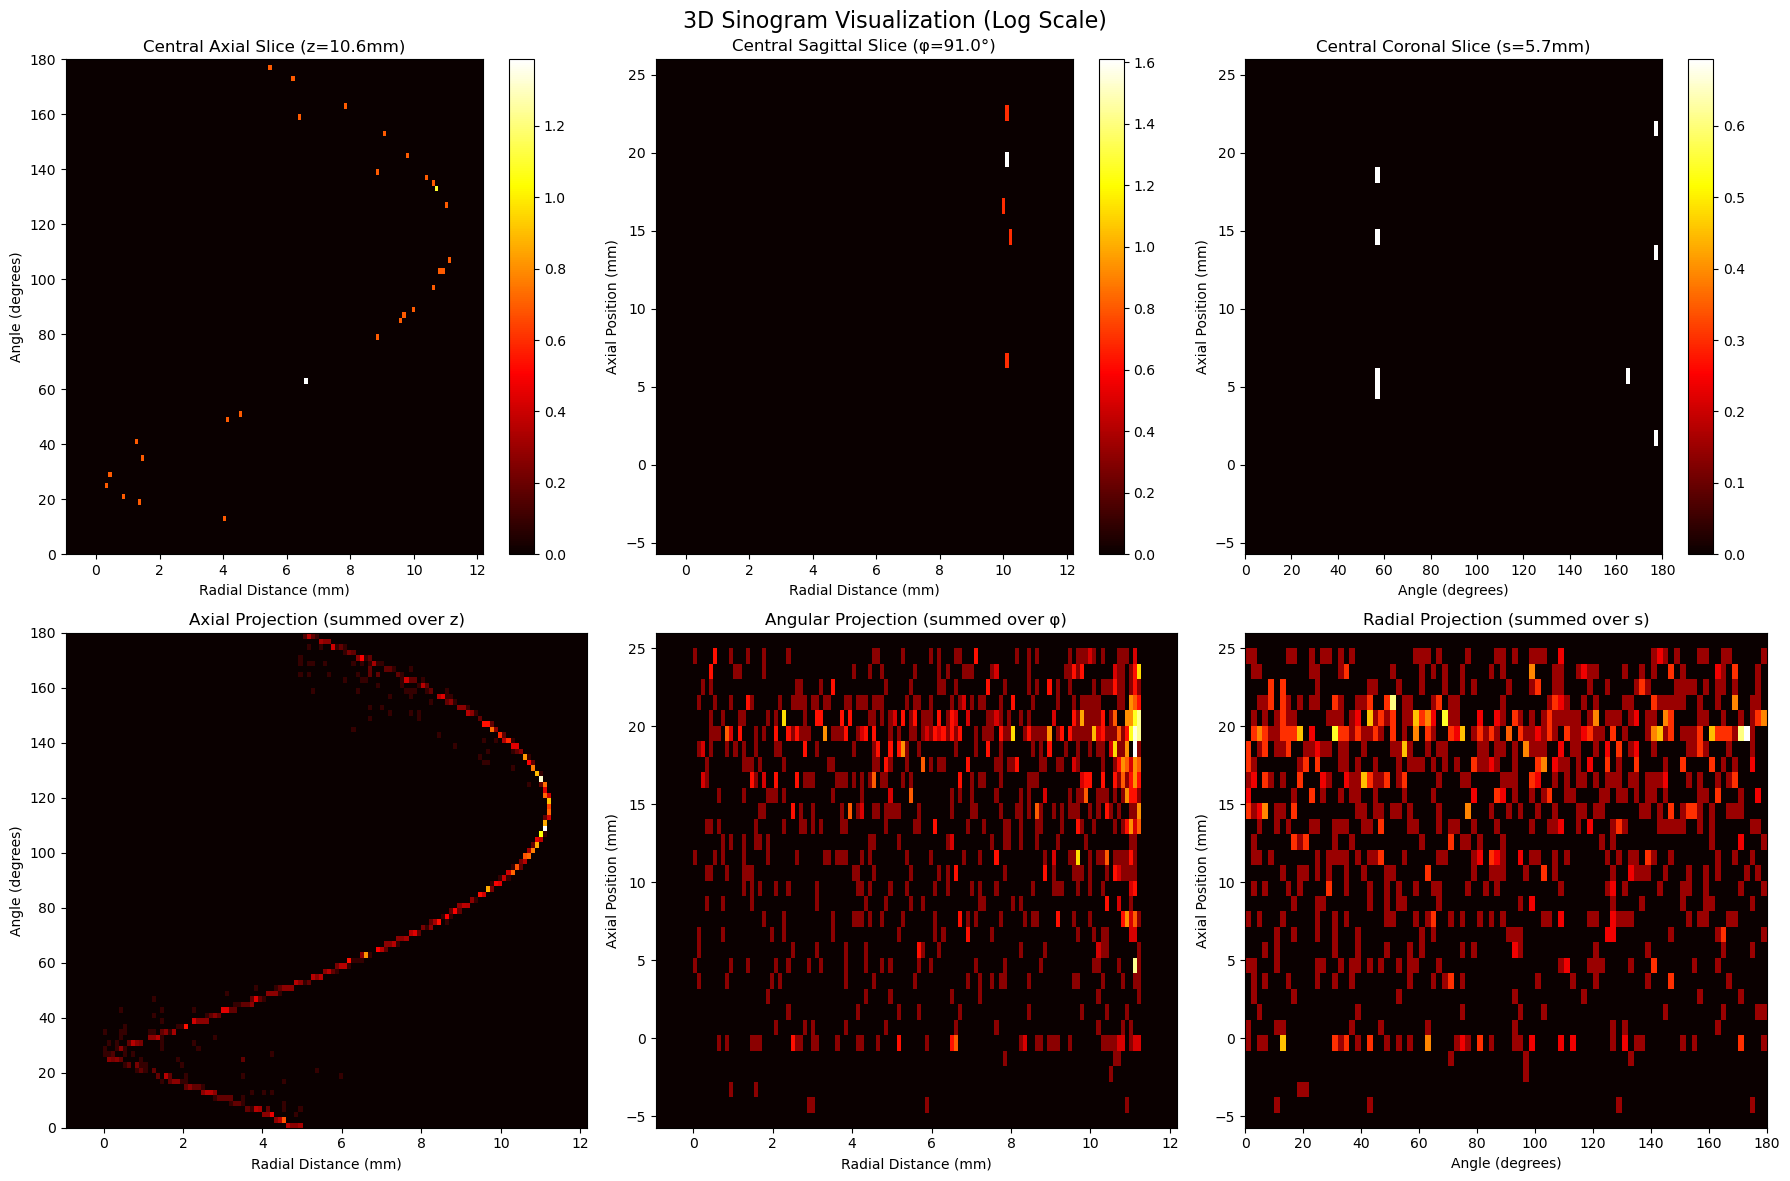


=== Data Quality Checks ===
⚠️  Very sparse 3D sinogram - check LOR coordinates
⚠️  Very uneven count distribution
✅ 3D sinogram analysis complete!


In [122]:
# Create full 3D sinogram
sinogram_3d, radial_coords, angular_coords, axial_coords = lor_coords_to_3d_sinogram(
    lor_coords=filtered_coordinates,
    weights=None,  # or your count weights
    n_radial_bins=128,    # s direction
    n_angular_bins=90,    # φ direction (0-180°)
    n_axial_bins=32       # z direction
)

print(f"3D sinogram shape: {sinogram_3d.shape}")  # (z, φ, s)

# Comprehensive analysis
sanity_check_3d_lor_data(filtered_coordinates)